# [Computational Social Science]
## 5-2 Exploratory Data Analysis and Unsupervised Methods - Solutions


This lab will demonstrate some exploratory methods for finding separating words, and introduce unsupervised topic models.

In [ ]:
#!pip install scattertext
#!pip install wordcloud
#!pip install textblob

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data

<img src = "../../images/cfpb logo.png"  />

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). This time, we are going to focus on figuring out whether we can find text features that help distinguish different "Products." There are several products represented in the dataset:

In [3]:
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Payday loan, title loan, or personal loan',
       'Credit card or prepaid card', 'Mortgage', 'Vehicle loan or lease',
       'Student loan'], dtype=object)

For the first few exercises, we will focus on mortgages and student loans. We will also just use the first one thousand observations so that the code runs faster. 

In [4]:
cfpb = cfpb[(cfpb['Product']=='Mortgage') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000]

In [5]:
cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,None,Servicemember,Consent provided,Web,02/18/20,Closed with explanation,Yes,NaN,3502248
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,We purchased our house in XX/XX/XXXX the Assig...,None,Ocwen Financial Corporation,ID,None,None,Consent provided,Web,02/10/20,Closed with explanation,Yes,NaN,3497147
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,None,I had past issues with Mortgage Solutions of C...,None,MORTGAGE SOLUTIONS OF COLORADO,TX,None,Servicemember,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3583812
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,None,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,Servicemember,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586865
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,None,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,None,None,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3588118


## Preprocessing

Let's start by creating our tokens. We'll use the same `rem_punc_stop()` function we defined last time.

In [6]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

Notice here how we use the `map()` function to apply our `rem_punc_stop()` function to every row of our dataframe. `map()` is typically much faster than writing a for loop, though there are also faster options like [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html) and vectorized numpy arrays.

In [7]:
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb['tokens']

213      [I, contacting, OCWEN, MORTGAGE, PHH, MORTGAGE...
216      [We, purchased, house, XXXXXXXX, Assignment, D...
283      [I, past, issues, Mortgage, Solutions, Colorad...
293      [I, called, Nationstar, multiple, times, reque...
387      [All, documents, short, sale, review, sent, XX...
                               ...                        
33836    [I, contacted, XXXX, XXXX, offering, complete,...
33855    [One, parent, plus, loan, opened, XXXXXXXX, ch...
33860    [TCF, refusing, provide, account, information,...
33880    [We, asking, loan, modification, years, In, pa...
33896    [loan, bayview, loan, services, went, 3,  , XX...
Name: tokens, Length: 1000, dtype: object

## Word Cloud

One of the most popular text analysis visualizations is the word cloud. Word clouds visualize the most frequent words in a corpus, and size them according to frequency.

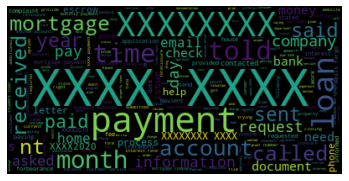

In [8]:
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

There are lots of ways to customize a word cloud, including by changing the background color:

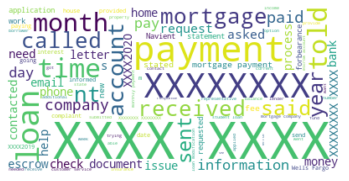

In [9]:
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

And we can even overlay the wordcloud onto an image:

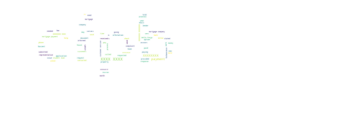

In [10]:
cfpb_mask = np.array(Image.open("../../images/cfpb logo.png"))
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white", 
                     mask = cfpb_mask,
                     width = 1000,
                     height = 1000).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Challenge

Notice that in the above word clouds, tokens like "XXXX" and "XXXXXXXX" appear frequently. These are redacted dates and likely won't help us with classification. Try to rewrite `rem_punc_stop` to remove these.

**Hint**: Try taking a look at `nlp.Defaults.stop_words` and see if there are any associated methods that might help.

In [11]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    # nlp.Defaults.stop_words.add("XX")
    # nlp.Defaults.stop_words.add("XXXX")
    # nlp.Defaults.stop_words.add("XXXXXXX")
    
    # Using the bitwise |= (or) operator
    nlp.Defaults.stop_words |= {"XX", "XXXX","XXXXXXXX"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

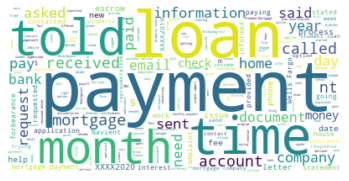

In [12]:
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Bonus**: This is an example where using [regular expressions](https://docs.python.org/3/library/re.html) can be useful. Instead of inputting all of the different ways that something like "XX" might show up, you can use regex to find and remove all similar patterns.

## Lengths and Counts

One of the basic things we might look for when analyzing text data is the length of a document. Let's see how we might grab the total number of characters and the total number of words:

In [13]:
cfpb['complaint_len'] = cfpb['Consumer complaint narrative'].apply(len)
cfpb['word_count'] = cfpb['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

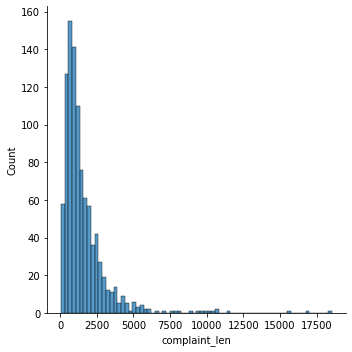

In [14]:
sns.displot(cfpb, x="complaint_len")
plt.show()

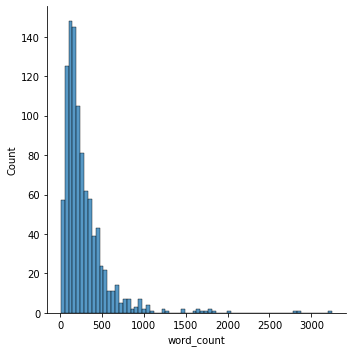

In [15]:
sns.displot(cfpb, x="word_count")
plt.show()

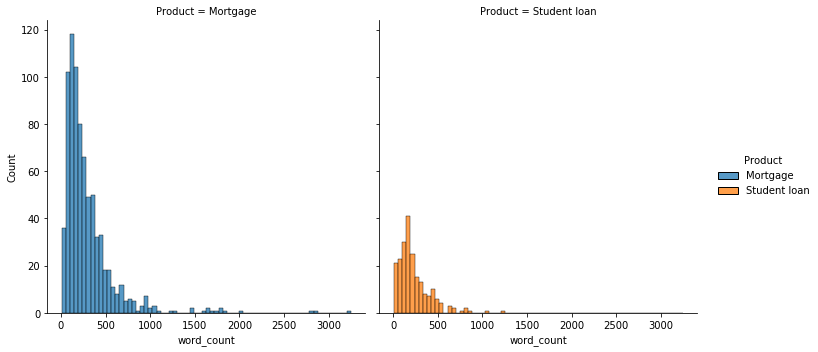

In [16]:
sns.displot(cfpb, x="word_count", hue = "Product", col = "Product")
plt.show()

## Sentiment Polarity

A common area of research in the social sciences is thinking about the "sentiment" of a text. The [`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html) library gives us access to a pre-trained sentiment analysis model. Text might be characterized as "positive," "negative," or "neutral" on a [-1,1] scale with -1 being highly negative and 1 being highly positive. Before we look at the code, do you expect that the sentiment scores for these data should be negative or positive? 

In [17]:
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,tokens,complaint_len,word_count,polarity
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,None,...,Web,02/18/20,Closed with explanation,Yes,NaN,3502248,I contacting OCWEN MORTGAGE PHH MORTGAGE AND a...,3075,552,0.122396
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,We purchased our house in XX/XX/XXXX the Assig...,None,Ocwen Financial Corporation,ID,None,...,Web,02/10/20,Closed with explanation,Yes,NaN,3497147,We purchased house Assignment Deed Trust signe...,308,55,0.092857
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,None,I had past issues with Mortgage Solutions of C...,None,MORTGAGE SOLUTIONS OF COLORADO,TX,None,...,Web,04/01/20,Closed with explanation,Yes,NaN,3583812,I past issues Mortgage Solutions Colorado LLC ...,889,154,0.151667
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,None,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,...,Web,03/31/20,Closed with explanation,Yes,NaN,3586865,I called Nationstar multiple times request upd...,654,121,0.050000
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,None,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,None,...,Web,03/31/20,Closed with explanation,Yes,NaN,3588118,All documents short sale review sent XXXX20 Sh...,1233,223,0.362500


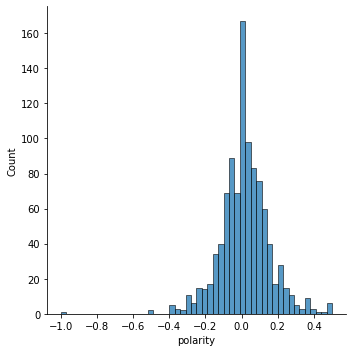

In [18]:
sns.displot(cfpb, x="polarity")
plt.show()

What's going on here? Why does sentiment look so close to neural, or even slightly positive? We know that all of the narratives in this dataset are consumer **complaints**, so we should expect them to look somewhat negative. Let's look at the 5 most positive reviews:

In [19]:
for complaint in cfpb.nlargest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + "\n")

the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes

I paid my XXXX mortgage with Bayview Loan Servicing LLC. I have a confirmation number for my payment, and my payment came out of my bank account. My agent said that a mistake had been made and that my account had been sent to foreclosure, but he took my payment anyway. He assured me, though, that he would contact his supervisor and have the process halted. This morning a woman and knocked on my door saying she represented a third-party and that my home was in foreclosure and she was doing an occupancy check. I contacted XXXX XXXX. XXXX said that Bayview is in the business of foreclosing on homes. I want to be placed with a more reputable mortgage company. You can not eve

Do we have any words that are skewing things? Let's look at the sentiment score for this first comment, and the individual sentiments of the words in it:

In [20]:
sample_complaint = "the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes"
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  0.5
the 0.0
company 0.0
said 0.0
they 0.0
are 0.0
offering 0.0
a 0.0
covid 0.0
relief 0.0
program 0.0
which 0.0
I 0.0
requested 0.0
assistance 0.0
and 0.0
they 0.0
are 0.0
saying 0.0
a 0.0
balloon 0.0
payment 0.0
is 0.0
owed 0.0
in 0.0
XXXX 0.0
I 0.0
called 0.0
the 0.0
company 0.0
and 0.0
I 0.0
was 0.0
told 0.0
that 0.0
if 0.0
I 0.0
can't 0.0
make 0.0
this 0.0
payment 0.0
they 0.0
will 0.0
be 0.0
talking 0.0
taking 0.0
litigation 0.0
steps 0.0
how 0.0
are 0.0
people 0.0
who 0.0
have 0.0
lost 0.0
their 0.0
job 0.0
able 0.5
to 0.0
keep 0.0
their 0.0
homes 0.0


Only one word actually has a sentiment score ("able")! TextBlob's sentiment polarity is not a simple average of all of the sentiments in a string - this is why preprocessing is important and why you should validate these types of off-the-shelf methods. Let's take a look at the most negative reviews and see if these make sense:

In [21]:
for complaint in cfpb.nsmallest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + '\n')

Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured.

I became ill last year and was unable to pay my mortgage because I was off from work. I have become delinquent and my home is set for a property foreclosure sale. I have requested mortgage assistance several times, the mortgage company has been difficult to work with me and refused to help me save my home

The company 1 file.org contacted me about student loan forgiveness. They charged me 3 payments of {$210.00} to process my paperwork and charged me a maintenance fee of {$29.00} XX/XX/XXXX, XX/XX/XXXX. I reached out to them in XX/XX/XXXX the phone number was no longer in business and no one never responded to my email. I am still unable to to find a contact for the business.

AmeriHome Mortgage is not refunding me my escrow money. I 

In [22]:
sample_complaint = "Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured."
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  -1.0
Navient 0.0
is 0.0
the 0.0
worst -1.0
company 0.0
to 0.0
ever 0.0
exist. 0.0
Website 0.0
does 0.0
not 0.0
work. 0.0
Do 0.0
the 0.0
people 0.0
at 0.0
customer 0.0
service 0.0
even 0.0
work 0.0
for 0.0
navient??? 0.0
They 0.0
don't 0.0
know 0.0
anything 0.0
about 0.0
whats 0.0
going 0.0
on. 0.0
Applied 0.0
for 0.0
a 0.0
repayement 0.0
plan 0.0
and 0.0
their 0.0
website 0.0
always 0.0
says 0.0
an 0.0
error 0.0
has 0.0
occured. 0.0


In this case we have a perfectly negative sentiment (-1.0), but again only one word is contirbuting - "worst". Sentiment polarity is a powerful tool, but not automatically suited to inference. That being said, maybe it can be helpful for distinguishing between labels. We can take a look at how polarity differs across mortgage and student loans:

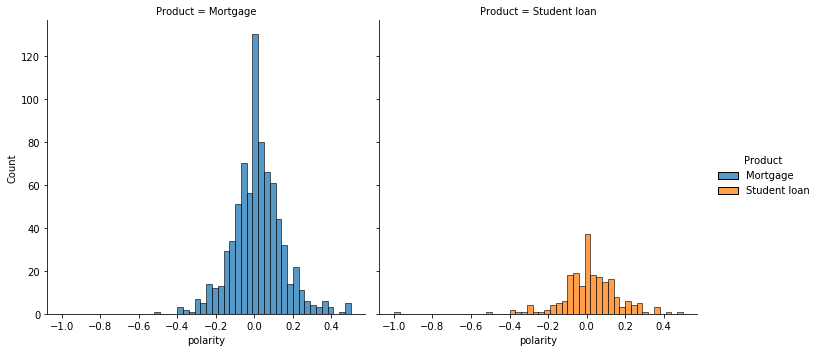

In [23]:
sns.displot(cfpb, x="polarity", hue = "Product", col = "Product")
plt.show()

### Challenge

In addition to sentiment polarity, TextBlob also has a method for determining how "objective" or "subjective" a piece of text is. Plot the objectivity measure by Product. Do these results make sense?

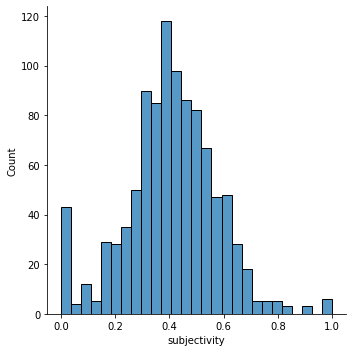

In [24]:
cfpb['subjectivity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(cfpb, x="subjectivity")
plt.show()

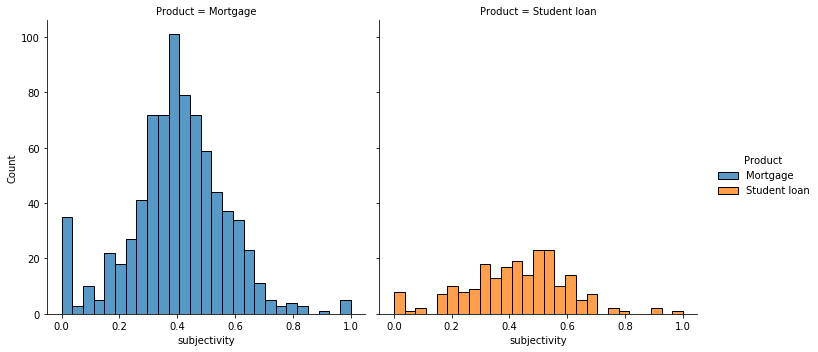

In [25]:
sns.displot(cfpb, x="subjectivity", hue = "Product", col = "Product")
plt.show()

**Answer**: We get "subjectivity" centered around .5, which means somewhere between objective and subjective. Maybe this makes sense as each complaint will be filled with both factual information and opinions about how the company is bad, but it is hard to say exactly.

## ScatterText

Next we'll take a look at a useful visualization for finding separarting words. We'll use the [ScatterText](https://spacy.io/universe/project/scattertext) library to visualize both word frequencies and how well they separate two classes.

In [26]:
corpus = st.CorpusFromPandas(cfpb[:5000],
                            category_col = 'Product',
                            text_col = 'tokens',
                            nlp = nlp).build()

In [27]:
html = st.produce_scattertext_explorer(corpus,
                                       category='Student loan',
                                       category_name='Student loan',
                                       not_category_name='Mortgage',
                                        width_in_pixels=1000,
                                        minimum_term_frequency=5,
                                       metadata=cfpb['Complaint ID'])

In [28]:
open("CFPB Sentiment.html", 'wb').write(html.encode('utf-8'))

2345851

## Unsupervised Methods

Finally, we'll look at unsupervised machine learning methods for text data. Specifically, we'll implement [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), which is a classic method for topic modeling. Topic models can help us uncover structure within a text. Specifically it does so through a "mixture model" - meaning every document is assumed to be "about" various topics, and we try to estimate the proportion each topic contributes to a document. Let's reload our cfpb dataset and look at "checkings or savings account" and "student loan" products this time:

In [30]:
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb = cfpb[(cfpb['Product']=='Checking or savings account') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000]

Let's start by creating our tf-idf matrix again:

In [31]:
X = cfpb['Consumer complaint narrative']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [1]:
# k means clustering

In [32]:
from sklearn.cluster import KMeans

In [34]:
kmeans = KMeans(n_clusters=3,
               max_iter=300
               ).fit(tfidf_matrix)

In [ ]:
# We can access the centers of the clusters through the cluster_centers_ attribute. To get the labels 
#(i.e. the corresponding cluster) we use labels_.

In [38]:
cfpb['cluster']= kmeans.labels_

In [39]:
cfpb

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,cluster
99,05/16/20,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,XXXX the XXXX I lost my card on a lunch run wh...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,750XX,None,Consent provided,Web,05/16/20,Closed with explanation,Yes,NaN,3655341,0
234,02/05/20,Checking or savings account,Checking account,Managing an account,Funds not handled or disbursed as instructed,In response to your answer dated XX/XX/XXXX. Y...,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,MO,658XX,Servicemember,Consent provided,Web,02/05/20,Closed with explanation,Yes,NaN,3521395,0
332,04/11/20,Checking or savings account,Other banking product or service,Opening an account,Confusing or missing disclosures,"On XX/XX/2020, my wife and I opened a business...",Company believes it acted appropriately as aut...,NAVY FEDERAL CREDIT UNION,FL,331XX,None,Consent provided,Web,04/11/20,Closed with explanation,Yes,NaN,3602599,0
346,04/01/20,Checking or savings account,Checking account,Opening an account,Didn't receive terms that were advertised,I signed up and opened a citibank checking acc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,606XX,None,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587986,0
397,04/01/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,"On XX/XX/2020, the CARES Act was signed into f...",None,AES/PHEAA,VA,223XX,None,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42908,01/15/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,My student loans were serviced by Navient. Cir...,None,"Navient Solutions, LLC.",MD,20715,None,Consent provided,Web,01/15/20,Closed with explanation,Yes,NaN,3496994,1
43000,01/15/20,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,On or about XXXX XXXX XXXX 2019 I used my debi...,Company has responded to the consumer and the ...,REGIONS FINANCIAL CORPORATION,GA,301XX,None,Consent provided,Web,01/15/20,Closed with explanation,Yes,NaN,3497316,2
43048,02/29/20,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,"On XX/XX/XXXX, I received a fraud check from a...",Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,951XX,None,Consent provided,Web,02/29/20,Closed with explanation,Yes,NaN,3548971,0
43049,02/26/20,Student loan,Private student loan,Dealing with your lender or servicer,Need information about your loan balance or lo...,Im filing a complaint against Ascendium/XXXX ...,None,Ascendium Education Group,VA,223XX,None,Consent provided,Web,02/26/20,Closed with explanation,Yes,NaN,3545561,2


Now that we have a dense matrix, let's apply our LDA model. The key hyperparameter here is the `n_components` argument. Let's start with 5, and then print out our topics to see what we get.

In [ ]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

We have 5 topics! Some seem to be sensible (i.e. topic 2 seems to be about banking while topic 3 is about student loans), but notice that the computer doedsn't find the right "topic names" for us automatically - so there is still a role for humans to interpret and make sense of the output.

## Topic weights

One thing we may want to do with the output is compare the prevalence of each topic across documents. A simple way to do this, is to merge the topic distribution back into the Pandas dataframe.

First get the topic distribution array.

In [ ]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

And then we'll merge back with original dataframe:

In [ ]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(cfpb.reset_index())
df_w_topics.head()

Now we can chech the average weight of each topic across Product using `groupby`.

In [ ]:
grouped = df_w_topics.groupby('Product')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

Topics 2 and 3 seem to have a lot of separation between checkings or savings account and student loans. Let's plot them:

In [ ]:
sns.displot(df_w_topics, x=df_w_topics[2], hue = "Product", kind = 'kde', fill = 'true')
plt.show()

In [ ]:
sns.displot(df_w_topics, x=df_w_topics[3], hue = "Product", kind = 'kde', fill = 'true')
plt.show()

This is a very clean separation! These two topics would be good candidates to pass to a supervised learning algorithm if we were interested in predicting the Product.

## Challenge

Try retraining the LDA witha  different number of topics, say 10. What do you notice? How is this similar to issues we've seen with other clustering algorithms?

In [ ]:
lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

**Answer**: The topics produced are very sensitive to our choice of `n`. This is similar to the problem with finding the right number of clusters in other unsupervised learning problems, like k-means.

---
Notebook developed by Aniket Kesari